In [1]:
# Imports
import gdown
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import warnings

fix_seed = 2021
warnings.filterwarnings('ignore')
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [2]:
# Download Influenza-like Illness (ILI) dataset
ILI_URL = 'https://drive.google.com/uc?id=1n4kDxT38rQEGmczIaYaaUWqRPWs-rtcH'
DS_NAME = 'ili.csv'
gdown.download(ILI_URL, DS_NAME)

Downloading...
From: https://drive.google.com/uc?id=1n4kDxT38rQEGmczIaYaaUWqRPWs-rtcH
To: /content/ili.csv
100%|██████████| 67.6k/67.6k [00:00<00:00, 45.1MB/s]


'ili.csv'

In [3]:
# define all the relevant exp vars
SEQ_LEN = 104
LABEL_LEN = 18
PRED_LEN = 60
ENC_IN = 7
INDIVIDUAL = False
LR = 0.01
BATCH_SIZE = 32
TREE_LR = 0.05
TREE_LOSS = 'Mixed'
TREE_LB = 104
TREE_ITER = 100
NUM_LEAVES = 3
PSMOOTH = 15
LB_DATA = 'N'
NUM_JOBS = 1
USE_GPU = False
DEVICE = 'cpu'
NORMALIZE = True
USE_REVIN = True

In [4]:
# Define RevIN and LTBoost

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.seq_len = SEQ_LEN
        self.pred_len = PRED_LEN
        self.channels = ENC_IN
        self.individual = INDIVIDUAL

        self.Tree = []
        self.tree_lr = TREE_LR
        self.tree_loss = TREE_LOSS
        self.treelb = min(TREE_LB, SEQ_LEN)
        self.lb_data = LB_DATA
        self.num_leaves = NUM_LEAVES
        self.tree_iter = TREE_ITER
        self.psmooth = PSMOOTH
        self.num_jobs = NUM_JOBS

        self.device =  'cuda' if USE_GPU else 'cpu'
        self.normalize = NORMALIZE
        self.use_RevIN = USE_REVIN

        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len)

        if self.use_RevIN:
            self.revin = RevIN(self.channels)

    def forward(self, X):
        # x: [Batch, Input length, Channel]
        # Only to train the Linear model
        if self.normalize:
            seq_last = X[:,-1:,:].detach()
            X = X - seq_last
        if self.use_RevIN:
            X = self.revin(X, 'norm')

        output = torch.zeros([X.size(0),self.pred_len,X.size(2)],dtype=X.dtype).to(X.device)
        if self.individual:
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](X[:,:,i])
        else:
            output = self.Linear(X.permute(0,2,1)).permute(0,2,1)

        if self.use_RevIN:
            output = self.revin(output, 'denorm')
        if self.normalize:
            output = output + seq_last

        return output # [Batch, Output length, Channel]

    def train(self, X, y):
        # X: [dataset size, Input length, Channel]
        # y: [dataset size, Output length, Channel]
        X, y = X.to(self.device), y.to(self.device)
        if self.normalize:
            seq_last = X[:,-1:,:]
            X = X - seq_last
            y = y - seq_last

        # Get predictions of Linear
        output = torch.zeros([X.size(0),self.pred_len,X.size(2)],dtype=X.dtype).to(X.device)
        with torch.no_grad():
            if self.use_RevIN:
                l_in = self.revin(X, 'norm')

            lin_in = X if not self.use_RevIN else l_in
            if self.individual:
                for i in range(self.channels):
                    output[:,:,i] = self.Linear[i](lin_in[:,:,i].float())
            else:
                output = self.Linear(lin_in.permute(0,2,1).float()).permute(0,2,1)

            if self.use_RevIN:
                output = self.revin(output, 'denorm')

        y = y - output

        if self.treelb > 0:
            if self.lb_data == '0':
                if self.normalize:
                    X += seq_last
                X = torch.cat((X[:,-self.treelb:,:], output), dim=1)
            elif self.lb_data == 'N':
                X = torch.cat((X[:,-self.treelb:,:], output), dim=1)
            else:
                X = torch.cat((lin_in[:,-self.treelb:,:], output), dim=1)
        else:
            X = output

        X, y = X.cpu().detach().numpy(), y.cpu().detach().numpy()

        self.Tree = []
        for i in range(self.channels):
            dtrain = lgb.Dataset(X[:,:,i])
            def multi_mse(y_hat, dtrain):
                y_true = y[:,:, i]
                grad = y_hat - y_true
                hess = np.ones_like(y_true)
                return grad.flatten("F"), hess.flatten("F")

            def pseudo_huber(y_hat, dtrain):
                y_true = y[:,:, i]
                d = (y_hat - y_true)
                h = 1  #h is delta, 1 = huber loss
                scale = 1 + (d / h) ** 2
                scale_sqrt = np.sqrt(scale)
                grad = d / scale_sqrt
                hess = 1 / scale / scale_sqrt
                return grad, hess

            def mixed_loss(y_hat, dtrain):
                # MSEloss
                y_true = y[:,:, i]
                grad1 = y_hat - y_true
                hess1 = np.ones_like(y_true)

                # Huberloss
                scale = 1 + grad1 ** 2
                scale_sqrt = np.sqrt(scale)
                grad2 = grad1 / scale_sqrt
                hess2 = 1 / scale / scale_sqrt
                return 0.5 * (grad1+grad2), 0.5 * (hess1+hess2)

            if self.tree_loss == 'Huber':
                loss_func = pseudo_huber
            elif self.tree_loss == 'Mixed':
                loss_func = mixed_loss
            else:
                loss_func = multi_mse

            self.Tree.append(
                lgb.train(
                    train_set=dtrain,
                    params = {
                        "boosting": "gbdt",
                        "objective": loss_func,
                        "num_class": self.pred_len,
                        "num_threads": self.num_jobs,
                        "num_leaves": self.num_leaves,
                        "learning_rate": self.tree_lr,
                        "num_iterations": self.tree_iter,
                        "force_col_wise":True,
                        "data_sample_strategy": "goss",
                        "path_smooth": self.psmooth,
                        "random_seed": 7,
                        "verbose": 1
                    },
                )
            )


    def predict(self, X):
        X = X.to(self.device)
        if self.normalize:
            seq_last = X[:,-1:,:]
            X = X - seq_last

        # Get predictions of Linear
        X = X.to(self.device)
        output = torch.zeros([X.size(0),self.pred_len,X.size(2)],dtype=X.dtype).to(X.device)
        with torch.no_grad():
            if self.use_RevIN:
                l_in = self.revin(X, 'norm')

            lin_in = X if not self.use_RevIN else l_in
            if self.individual:
                for i in range(self.channels):
                    output[:,:,i] = self.Linear[i](lin_in[:,:,i].float())
            else:
                output = self.Linear(lin_in.permute(0,2,1).float()).permute(0,2,1)

            if self.use_RevIN:
                output = self.revin(output, 'denorm')

        if self.treelb > 0:
            if self.lb_data == '0':
                if self.normalize:
                    X += seq_last
                X = torch.cat((X[:,-self.treelb:,:], output), dim=1)
            elif self.lb_data == 'N':
                X = torch.cat((X[:,-self.treelb:,:], output), dim=1)
            else:
                X = torch.cat((lin_in[:,-self.treelb:,:], output), dim=1)
        else:
            X = output

        X, output = X.cpu().detach().numpy(), output.cpu().detach(),

        output2 = torch.zeros([output.size(0),self.pred_len,output.size(2)],dtype=output.dtype).to(output.device)
        for i in range(self.channels):
            dtest = X[:,:,i]
            output2[:,:,i] = torch.tensor(self.Tree[i].predict(dtest, num_threads=10), dtype=torch.double)

        if self.normalize:
            seq_last = seq_last.cpu()
            output = output + seq_last

        return output + output2

In [5]:
# Define Dataset

class Dataset_Custom(Dataset):
    def __init__(self, flag='train', data_path=DS_NAME, scale=True, train_only=False):
        # size [seq_len, label_len, pred_len]
        self.seq_len = SEQ_LEN
        self.label_len = LABEL_LEN
        self.pred_len = PRED_LEN
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.scale = scale
        self.train_only = train_only

        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(self.data_path)

        cols = list(df_raw.columns)
        cols.remove('date')
        num_train = int(len(df_raw) * (0.7 if not self.train_only else 1))
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        df_raw = df_raw[['date'] + cols]
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]

        return seq_x, seq_y

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

def validate(model, vali_loader, criterion):
        errs = []
        with torch.no_grad():
            for batch_x, batch_y in vali_loader:
                batch_x = batch_x.float().to(DEVICE)
                batch_y = batch_y[:, -PRED_LEN:,:].float().to(DEVICE)
                outputs = model(batch_x)
                outputs = outputs[:, -PRED_LEN:,:]
                pred = outputs.detach().cpu()
                true = batch_y.detach().cpu()
                loss = criterion(pred, true)
                errs.extend(np.abs(pred-true))

        return np.mean(np.array(errs)**2), np.mean(errs)

In [6]:
# Load Model and Data
ltboost = Model()

train_loader = DataLoader(
    Dataset_Custom(flag='train'),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    drop_last=True)

vali_loader = DataLoader(
    Dataset_Custom(flag='val'),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    drop_last=True)

test_loader = DataLoader(
    Dataset_Custom(flag='test'),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    drop_last=False)

In [7]:
# Train linear part and evaluate it
EPOCHS = 10
PATIENCE = 3
model_optim = optim.Adam(ltboost.parameters(), lr=LR)
criterion = nn.L1Loss()
ltboost = ltboost.to(DEVICE)


print("======= Training of linear part starting... =======")
time_now = time.time()
train_steps = len(train_loader)
best_val_loss, final_mse, final_mae, rounds_count = float('inf'), 0, 0, 0
for epoch in range(EPOCHS):
    iter_count = 0
    train_loss = []

    epoch_time = time.time()
    for i, (batch_x, batch_y) in enumerate(train_loader):
        iter_count += 1
        model_optim.zero_grad()
        batch_x = batch_x.float().to(DEVICE)
        batch_y = batch_y.float().to(DEVICE)

        outputs = ltboost(batch_x)
        outputs = outputs[:, -ltboost.pred_len:,:]
        batch_y = batch_y[:, -ltboost.pred_len:,:].to(DEVICE)
        loss = criterion(outputs, batch_y)
        train_loss.append(loss.item())

        if (i + 1) % 100 == 0:
            print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
            speed = (time.time() - time_now) / iter_count
            left_time = speed * ((EPOCHS - epoch) * train_steps - i)
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            time_now = time.time()

        loss.backward()
        model_optim.step()
    print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
    train_loss = np.average(train_loss)

    vali_mse, vali_mae = validate(ltboost, vali_loader, criterion)
    test_mse, test_mae = validate(ltboost, test_loader, criterion)
    print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f}/{4:.7f} Test Loss: {5:.7f}/{6:.7f}".format(
        epoch + 1, train_steps, train_loss, vali_mse, vali_mae, test_mse, test_mae))

    if vali_mae < best_val_loss:
        best_val_loss = vali_mae
        final_mse, final_mae = test_mse, test_mae
        rounds_count = 0
    else:
        rounds_count +=1

    print(f'EarlyStopping counter: {rounds_count} out of {PATIENCE}')
    if rounds_count == PATIENCE:
        print("Early stopping")
        break

    lr_adjust = {epoch: LR * (0.5 ** (epoch // 1))}
    lr = lr_adjust[epoch]
    for param_group in model_optim.param_groups:
        param_group['lr'] = lr
    print('Updating learning rate to {}'.format(lr))

print('======= Final test loss (MSE/MAE): {0:.7f}/{1:.7f} ======='.format(final_mse, final_mae))

======= Training of linear part starting... =======
Epoch: 1 cost time: 0.8784863948822021
Epoch: 1, Steps: 16 | Train Loss: 0.5257909 Vali Loss: 0.2781432/0.3421107 Test Loss: 1.9937780/0.9637004
EarlyStopping counter: 0 out of 3
Updating learning rate to 0.01
Epoch: 2 cost time: 0.752152681350708
Epoch: 2, Steps: 16 | Train Loss: 0.4256922 Vali Loss: 0.2801777/0.3414940 Test Loss: 1.9022088/0.9208804
EarlyStopping counter: 0 out of 3
Updating learning rate to 0.005
Epoch: 3 cost time: 0.49935078620910645
Epoch: 3, Steps: 16 | Train Loss: 0.3954253 Vali Loss: 0.2492639/0.3099774 Test Loss: 1.8800025/0.9215587
EarlyStopping counter: 0 out of 3
Updating learning rate to 0.0025
Epoch: 4 cost time: 0.40905237197875977
Epoch: 4, Steps: 16 | Train Loss: 0.3850239 Vali Loss: 0.2541665/0.3026867 Test Loss: 1.8287795/0.8937352
EarlyStopping counter: 0 out of 3
Updating learning rate to 0.00125
Epoch: 5 cost time: 0.4420502185821533
Epoch: 5, Steps: 16 | Train Loss: 0.3784903 Vali Loss: 0.25681

In [8]:
# Train LGBM part
# Get full dataset for LGBM
X_batches, y_batches = [], [],
for batch_X, batch_y in train_loader:
    X_batches.append(batch_X.float())
    y_batches.append(batch_y[:, -PRED_LEN:,:].float())
X, y = torch.cat(X_batches, dim=0), torch.cat(y_batches, dim=0)

# Train LGBM
time_start = time.time()
print("Start LGBM Training")
ltboost.train(X, y)
time_train = time.time()

print("Predicting")
outputs = ltboost.predict(X)
time_predict = time.time()
outputs = outputs.detach().cpu().numpy()
y = y.detach().cpu().numpy()
errs = np.abs(outputs - y)
train_mse, train_mae = np.mean(np.array(errs)**2), np.mean(errs)

print("Training time: {0:.2f}".format(time_train - time_start))
print("(Train) Prediction time: {0:.2f}".format(time_predict - time_train))

Start LGBM Training
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 27873
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 163
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 27873
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 163
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 27875
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 163
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 2787

In [9]:
# Evaluate LTBoost on val and test
def vali(model, d_loader):

    X_batches, y_batches = [], [],
    for batch_X, batch_y in d_loader:
        X_batches.append(batch_X.float())
        y_batches.append(batch_y[:, -PRED_LEN:,:].float())
    X, y = torch.cat(X_batches, dim=0), torch.cat(y_batches, dim=0)

    outputs = model.predict(X)
    outputs = outputs.detach().cpu().numpy()
    y = y.numpy()
    errs = np.abs(y - outputs)
    mae, mse,= np.mean(np.array(errs)**2), np.mean(errs)
    return mse, mae


vali_mae, vali_mse = vali(ltboost, vali_loader)
test_mae, test_mse = vali(ltboost, test_loader)
print("(mse/mae) Train: {0:.7f}/{1:.7f} Vali: {2:.7f}/{3:.7f} Test: {4:.7f}/{5:.7f}".format(
                train_mse, train_mae, vali_mse, vali_mae, test_mse, test_mae))

(mse/mae) Train: 0.3172062/0.3043743 Vali: 0.2453585/0.3319528 Test: 1.7614886/0.8353900


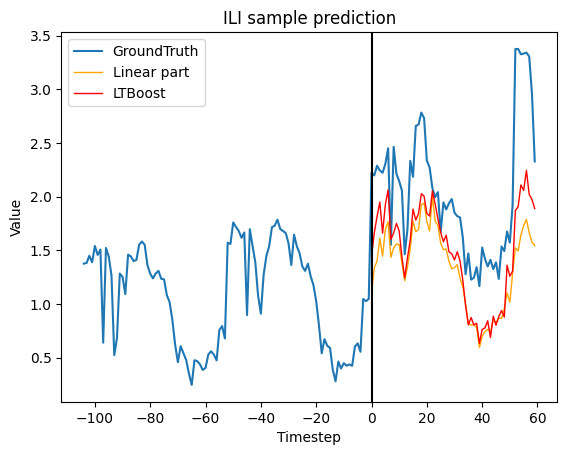

In [10]:
# Prediction example
X_batch, y_batch = next(iter(test_loader))
with torch.no_grad():
    lin_preds = ltboost(X_batch.float())
lt_preds = ltboost.predict(X_batch)

gt = np.concatenate((X_batch[10,:,-1], y_batch[10,-PRED_LEN:,-1]), axis=0)
plt.figure()
plt.plot(list(range(-SEQ_LEN, PRED_LEN)), gt, label='GroundTruth', linewidth=1.5)
plt.plot(list(range(PRED_LEN)), lin_preds[10,:,-1], label='Linear part', color='orange', linewidth=1)
plt.plot(list(range(PRED_LEN)), lt_preds[10,:,-1], label='LTBoost', color='red', linewidth=1)
plt.axvline(x=0, color="k")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title('ILI sample prediction')
plt.legend()